<a href="https://colab.research.google.com/github/lucguittard/DS-Unit-2-Applied-Modeling/blob/master/DSproject2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Authorizing access to G-Drive

In [2]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Making a new df

### Reading-In and Initial Edits 

In [0]:
path = "/content/drive/My Drive/dsProject2/household-debt/household-debt-by-county.csv"
df = pd.read_csv(path)                         #2013-2017
path2 = "/content/drive/My Drive/dsProject2/Rural_Atlas_Update20/Income.csv" 
df2 = pd.read_csv(path2, encoding='latin-1')   #2018-2019
path = '/content/drive/My Drive/dsProject2/Rural_Atlas_Update20/County Classifications.csv'
df3 = pd.read_csv(path, encoding='latin-1')    #2013-2015
path4 = '/content/drive/My Drive/dsProject2/Rural_Atlas_Update20/Veterans.csv'
df4 = pd.read_csv('/content/drive/My Drive/dsProject2/Rural_Atlas_Update20/Veterans.csv', encoding='latin-1') #2018-2019
path5 = '/content/drive/My Drive/dsProject2/Rural_Atlas_Update20/People.csv'      #2010-2019
df5 = pd.read_csv(path5, encoding='latin-1')
path6 = '/content/drive/My Drive/dsProject2/Rural_Atlas_Update20/Jobs.csv'        #2018-2019
df6 = pd.read_csv(path6, encoding='latin-1') 
path9 = '/content/drive/My Drive/dsProject2/2015CountyTypologyCodes.csv'          #2013-2015
df9 = pd.read_csv(path9, encoding='latin-1')
path10 = '/content/drive/My Drive/dsProject2/creativeclass200711.csv'             #2007-2011
df10 = pd.read_csv(path10, encoding='latin-1')

In [0]:
df = df.rename(columns = {"area_fips": "FIPS"})
mask = (df['year'] > 2012)
df = df[mask]

df2 = df2.drop(0)

df3 = df3.rename(columns = {'FIPStxt': 'FIPS'})
df3 = df3[['FIPS','RuralUrbanContinuumCode2013','Low_Education_2015_update','Low_Employment_2015_update',
           'Population_loss_2015_update', 'Metro_Adjacent2013']]

df4 = df4.drop(0)
df4 = df4[['FIPS','Vets18OPct','MaleVetsPct','PctVetsPoor','PctNonVetsPoor','PctVetsDisabilty','PctNonVetsDisabilty']]

df5 = df5.drop(0)
df5 = df5[['FIPS','PopChangeRate1018','NetMigrationRate1018','PopDensity2010','Under18Pct2010','Age65AndOlderPct2010','ForeignBornPct']]

df6 = df6.drop(0)
df6 = df6[['FIPS','UnempRate2018','UnempRate2015','PctEmpChange1018','PctEmpAgriculture','PctEmpMining','PctEmpConstruction','PctEmpManufacturing',
          'PctEmpTrade','PctEmpTrans','PctEmpInformation','PctEmpFIRE','PctEmpServices','PctEmpGovt']]

df9 = df9.rename(columns = {'FIPStxt': 'FIPS'})
df9 = df9[['FIPS','Metro-nonmetro status, 2013 0=Nonmetro 1=Metro','Persistent_Poverty_2013',
           'Persistent_Related_Child_Poverty_2013','Economic_Type_Label','Economic Types Type_2015_Update non-overlapping']]

df10 = df10[['FIPS','CCShare','CCShareSE','BohShare','BohShareSE','CCShareRME','BohShareRME','metro03']]

### Merging County-lvl. Data

In [0]:
merge1 = pd.merge(df,df2, on='FIPS')
merge2 = pd.merge(merge1,df3,on='FIPS')
merge3 = pd.merge(merge2,df4, on = 'FIPS')
merge4 = pd.merge(merge3,df5, on = 'FIPS')
merge5 = pd.merge(merge4,df6, on = 'FIPS')
merge6 = pd.merge(merge5,df9, on = 'FIPS')
merge7 = pd.merge(merge6,df10, on = 'FIPS')

merge7.to_csv('/content/drive/My Drive/dsProject2/merge7.csv', index = False)
merge7.shape

NameError: ignored

## Work on full dataset

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
dfv = pd.read_csv('/content/drive/My Drive/dsProject2/merge7.csv')
dfv = dfv.drop(columns = ['State', 'County'])

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (51,52,53,54,55,56) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
dfv.head()

,year,qtr,FIPS,low,high,MedHHInc,PerCapitaInc,PovertyUnder18Pct,PovertyAllAgesPct,Deep_Pov_All,Deep_Pov_Children,PovertyUnder18Num,PovertyAllAgesNum,RuralUrbanContinuumCode2013,Type_2015_Update,Low_Education_2015_update,Low_Employment_2015_update,Population_loss_2015_update,Metro_Adjacent2013,Vets18OPct,MaleVetsPct,PctVetsPoor,PctNonVetsPoor,PctVetsDisabilty,PctNonVetsDisabilty,PopChangeRate1018,NetMigrationRate1018,PopDensity2010,Under18Pct2010,Age65AndOlderPct2010,ForeignBornPct,UnempRate2018,UnempRate2015,PctEmpChange1018,PctEmpAgriculture,PctEmpMining,PctEmpConstruction,PctEmpManufacturing,PctEmpTrade,PctEmpTrans,PctEmpInformation,PctEmpFIRE,PctEmpServices,PctEmpGovt,"Metro-nonmetro status, 2013 0=Nonmetro 1=Metro",Persistent_Poverty_2013,Persistent_Related_Child_Poverty_2013,Economic_Type_Label,Economic Types Type_2015_Update non-overlapping,CCShare,CCShareSE,BohShare,BohShareSE,CCShareRME,BohShareRME,metro03
0,2013,1,1001,3.46,NaN,58343.0,27824.0,19.3,13.4,5.85432,9.668756,2542.0,7390.0,2.0,0.0,0.0,0.0,0.0,0.0,12.562753,89.544132,3.43461,13.985967,18.626156,15.676579,1.55,0.28,91.8,26.78,12.0,2.113162,3.6,5.0,6.76,0.605508,0.315196,5.134373,13.321168,12.881553,7.436131,1.671367,5.573988,41.908593,11.152123,1,0,0,Nonspecialized,0,0.23529,0.01264,0.0058,0.00168,0.02079,0.00277,1
1,2013,2,1001,3.46,NaN,58343.0,27824.0,19.3,13.4,5.85432,9.668756,2542.0,7390.0,2.0,0.0,0.0,0.0,0.0,0.0,12.562753,89.544132,3.43461,13.985967,18.626156,15.676579,1.55,0.28,91.8,26.78,12.0,2.113162,3.6,5.0,6.76,0.605508,0.315196,5.134373,13.321168,12.881553,7.436131,1.671367,5.573988,41.908593,11.152123,1,0,0,Nonspecialized,0,0.23529,0.01264,0.0058,0.00168,0.02079,0.00277,1
2,2013,3,1001,3.46,NaN,58343.0,27824.0,19.3,13.4,5.85432,9.668756,2542.0,7390.0,2.0,0.0,0.0,0.0,0.0,0.0,12.562753,89.544132,3.43461,13.985967,18.626156,15.676579,1.55,0.28,91.8,26.78,12.0,2.113162,3.6,5.0,6.76,0.605508,0.315196,5.134373,13.321168,12.881553,7.436131,1.671367,5.573988,41.908593,11.152123,1,0,0,Nonspecialized,0,0.23529,0.01264,0.0058,0.00168,0.02079,0.00277,1
3,2013,4,1001,3.46,NaN,58343.0,27824.0,19.3,13.4,5.85432,9.668756,2542.0,7390.0,2.0,0.0,0.0,0.0,0.0,0.0,12.562753,89.544132,3.43461,13.985967,18.626156,15.676579,1.55,0.28,91.8,26.78,12.0,2.113162,3.6,5.0,6.76,0.605508,0.315196,5.134373,13.321168,12.881553,7.436131,1.671367,5.573988,41.908593,11.152123,1,0,0,Nonspecialized,0,0.23529,0.01264,0.0058,0.00168,0.02079,0.00277,1
4,2014,1,1001,3.46,NaN,58343.0,27824.0,19.3,13.4,5.85432,9.668756,2542.0,7390.0,2.0,0.0,0.0,0.0,0.0,0.0,12.562753,89.544132,3.43461,13.985967,18.626156,15.676579,1.55,0.28,91.8,26.78,12.0,2.113162,3.6,5.0,6.76,0.605508,0.315196,5.134373,13.321168,12.881553,7.436131,1.671367,5.573988,41.908593,11.152123,1,0,0,Nonspecialized,0,0.23529,0.01264,0.0058,0.00168,0.02079,0.00277,1


### Baseline 
Want to predict debt rates (here, the low-end estimate) - much data missing for high-end

In [47]:
dfv['low'] = pd.cut(dfv['low'],2,labels = False) #specify 2 class. for binary set -> use w/ ROC-AUC
dfv['low'].value_counts(normalize=True) 
#baseline (majority class) = 0.404 
# classes are imbalanced -> tryout ROC and class_weight param (scikit learn)

0    0.708627
1    0.291373
Name: low, dtype: float64

### Exploratory visuals

### Split + Data Wrangling


In [6]:
dfv.year.value_counts()

2014    12532
2013    12532
2015    12531
2017    12530
2016    12530
Name: year, dtype: int64

In [7]:
dfv.high.isna().sum()

5629

In [8]:
dfv.describe() #search for outliers

,year,qtr,FIPS,low,high,MedHHInc,PerCapitaInc,PovertyUnder18Pct,PovertyAllAgesPct,Deep_Pov_All,Deep_Pov_Children,PovertyUnder18Num,PovertyAllAgesNum,RuralUrbanContinuumCode2013,Type_2015_Update,Low_Education_2015_update,Low_Employment_2015_update,Population_loss_2015_update,Metro_Adjacent2013,Vets18OPct,MaleVetsPct,PctVetsPoor,PctNonVetsPoor,PctVetsDisabilty,PctNonVetsDisabilty,PopChangeRate1018,NetMigrationRate1018,PopDensity2010,Under18Pct2010,Age65AndOlderPct2010,ForeignBornPct,UnempRate2018,UnempRate2015,PctEmpChange1018,PctEmpAgriculture,PctEmpMining,PctEmpConstruction,PctEmpManufacturing,PctEmpTrade,PctEmpTrans,PctEmpInformation,PctEmpFIRE,PctEmpServices,PctEmpGovt,"Metro-nonmetro status, 2013 0=Nonmetro 1=Metro",Persistent_Poverty_2013,Persistent_Related_Child_Poverty_2013,Economic Types Type_2015_Update non-overlapping,metro03
count,62655.000000,62655.000000,62655.000000,62655.000000,57026.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,6.265500e+04,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,62635.000000,62633.000000,62655.000000,62633.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000,62655.000000
mean,2014.999904,2.499912,30434.477903,1.788828,1.784266,51090.927859,26028.989466,21.539181,15.369999,6.837130,9.862390,4260.963642,1.358945e+04,4.999745,1.803224,0.149070,0.288501,0.168191,0.325529,9.131256,93.251904,10.292955,15.725721,21.710711,13.069458,0.912304,-0.068713,259.875793,23.424248,15.889234,4.699224,4.117328,5.081973,4.143761,5.109760,1.657380,7.236874,12.314099,13.740817,5.499841,1.401149,4.567650,42.877837,5.594593,0.371878,0.112042,0.225345,1.803224,0.347618
std,1.414225,1.118036,15122.689325,1.138752,0.795370,13499.325639,6245.052428,9.104896,6.248520,3.365953,6.053082,15299.468105,4.717956e+04,2.704962,1.816347,0.356161,0.453069,0.374039,0.468576,2.653430,3.515534,7.026248,6.499362,9.748714,4.581544,7.488828,6.475147,1726.633879,3.315113,4.176274,5.700756,1.453532,2.008620,11.297478,6.355135,3.543960,2.313199,7.191012,2.678393,2.042336,0.844417,1.881224,6.959250,3.175156,0.483310,0.315421,0.417813,1.816347,0.476218
min,2013.000000,1.000000,1001.000000,0.000000,0.780000,22679.000000,10960.000000,2.700000,3.000000,0.000000,0.000000,11.000000,1.300000e+01,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,71.826625,0.000000,0.000000,0.000000,0.967742,-26.150000,-25.880000,0.040000,9.110000,3.470000,0.000000,1.300000,1.000000,-32.680000,0.000000,0.000000,0.000000,0.000000,1.156069,0.000000,0.000000,0.000000,5.128205,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2014.000000,1.000000,19003.000000,1.000000,1.190000,42275.000000,21805.000000,14.800000,10.900000,4.552548,5.684925,509.000000,1.636000e+03,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.550806,91.666667,5.933251,11.007071,15.504587,9.812482,-3.730000,-3.710000,17.050000,21.430000,13.130000,1.354839,3.100000,4.000000,-2.690000,1.136425,0.080877,5.659038,6.718598,12.319050,4.172427,0.880626,3.393541,38.254865,3.570954,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2015.000000,2.000000,29181.000000,2.000000,1.580000,48851.000000,25267.000000,20.500000,14.400000,6.293835,8.848700,1210.000000,3.893000e+03,6.000000,1.000000,0.000000,0.000000,0.000000,0.000000,8.898224,93.523833,9.268293,15.003651,20.443430,12.526395,-0.400000,-1.050000,45.300000,23.330000,15.570000,2.691027,3.900000,5.000000,3.460000,2.863436,0.311268,6.964006,11.441608,13.921248,5.156076,1.318681,4.275394,42.666369,4.731340,0.000000,0.000000,0.000000,1.000000,0.000000
75%,2016.000000,3.000000,45081.000000,3.000000,2.160000,56678.000000,29096.000000,26.700000,18.400000,8.303840,12.633262,2850.00

In [48]:
#holdout test set
test = dfv.query('year == 2017') 

# Split train into train & val
#dfv['averageDebtRate'] = (dfv['low'] + dfv['high'])

#split on time-series
re_train = dfv.query('year < 2016')
re_val = dfv.query('year == 2016') #val set approx. 25% of (post- test-split) dataset 
print(re_train.shape,re_val.shape)

#split by random
train, val = train_test_split(test, train_size=0.80, stratify=test['low'], random_state=12)
train.shape, val.shape

(37595, 56) (12530, 56)


((10024, 56), (2506, 56))

In [0]:
# import pandas_profiling as pp
# pp.ProfileReport(train)

In [0]:
def wrangle(X):    
    X = X.copy()
    target = X.low
    
    #managing outliers
    X['MedHHInc'] = X.query('MedHHInc < 70000')
    X['PerCapitaInc'] = X.query('PerCapitaInc < 45000')
    X['PovertyUnder18Pct'] = X.query('PovertyUnder18Pct < 40')
    X['PovertyAllAgesPct'] = X.query('PovertyAllAgesPct < 35')
    X['Deep_Pov_All'] = X.query('Deep_Pov_All < 18')
    
    
    #feat/engineering
    X = X.drop(columns=['high']) #column of (many) nan
    X = X.query('qtr == 4')
    
    # Drop duplicate columns --> none yet
    duplicates = []
    X = X.drop(columns=duplicates)
    
    # Drop unusable variances
    unusable_variance = ['FIPS','year','qtr']
    X = X.drop(columns=unusable_variance)
    
    #bin the y-continuous feat
    X['low'] = pd.cut(X['low'],2,labels = False) #labels = False -> bins are indicated by integer values
    
    # return the wrangled dataframe
    return X
  
def wrangle2(X):
    least_feats = list_feats[35:]
    X = X.copy()
    X = X.query('qtr == 4')
    X['MedHHInc'] = X.query('MedHHInc < 70000')
    X['PerCapitaInc'] = X.query('PerCapitaInc < 45000')
    X['PovertyUnder18Pct'] = X.query('PovertyUnder18Pct < 40')
    X['PovertyAllAgesPct'] = X.query('PovertyAllAgesPct < 35')
    X['Deep_Pov_All'] = X.query('Deep_Pov_All < 18')
    X = X.drop(columns = least_feats)
    X = X.drop(columns = ['FIPS','high','year','qtr'])
 
    return X
  
train = wrangle(train)
val = wrangle(val)
re_train = wrangle(re_train)
re_val = wrangle(re_val)
test = wrangle(test)

In [0]:
# The status_group column is the target
target = 'low'

train_features = train.drop(columns=[target])
re_train_features = re_train.drop(columns = [target])

# list of numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()
re_numeric_features = re_train_features.select_dtypes(include='number').columns.tolist()

# # series with cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()
re_cardinality = re_train_features.select_dtypes(exclude='number').nunique()

# list of categorical features w/cardinality <= 25Pct
categorical_features = cardinality[cardinality <= 50].index.tolist() #none w/wrangle2 function; all w/cards in 1000s
re_categorical_features = re_cardinality[re_cardinality <= 10].index.tolist()

# combine lists 
features = numeric_features + categorical_features
re_features = re_numeric_features + categorical_features

In [0]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

re_X_train = re_train[re_features]
re_y_train = re_train[target]
re_X_val = re_val[re_features]
re_y_val = re_val[target]

### Baseline + Confusion Matrix

In [52]:
#baseline
import numpy as np
from sklearn.metrics import accuracy_score

y_train.value_counts(normalize=True)  #baseline = .415 (class 1)

0    0.738236
1    0.261764
Name: low, dtype: float64

In [61]:
#Accuracy score for baseline
majority_class = y_train.mode()[0]
y_pred = np.full_like(y_val, fill_value=majority_class)
accuracy_score(y_val, y_pred) 

0.7201986754966887

In [60]:
#confusion matrix for majority class baseline
#from sklearn.metrics import confusion_matrix
y_pred = pipeline.predict(X_val)
confusion_matrix(y_val, y_pred)

array([[ 70, 261,  86,  17,   1],
       [  0,   1,  24,  82,  62],
       [  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0]])

In [55]:
#precision and recall for model/majority class baseline
from sklearn.metrics import classification_report #confusion matrix used for multi-class. types
print(classification_report(y_val, y_pred)) 

              precision    recall  f1-score   support

           0       1.00      0.16      0.28       435
           1       0.00      0.01      0.00       169
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0

    accuracy                           0.12       604
   macro avg       0.20      0.03      0.06       604
weighted avg       0.72      0.12      0.20       604



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### ROC-AUC

In [56]:
#roc & auc for majority class baseline
from sklearn.metrics import roc_auc_score  #works with binary class. types

y_pred_proba = np.full_like(y_val, fill_value=1.00)
roc_auc_score(y_val, y_pred_proba)

0.5

In [58]:
#roc/auc for model
y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred_proba) #very poor score (0.115)

0.11493572740257091

In [0]:
from ipywidgets import interact, fixed
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils.multiclass import unique_labels

def set_threshold(y_true, y_pred_proba, threshold=0.5):
    """
    For binary classification problems. 
    y_pred_proba : predicted probability of class 1
    """
    
    # Apply threshold to predicted probabilities
    # to get discrete predictions
    class_0, class_1 = unique_labels(y_true)
    y_pred = np.full_like(y_true, fill_value=class_0)
    y_pred[y_pred_proba > threshold] = class_1
    
    # Plot distribution of predicted probabilities
    ax = sns.distplot(y_pred_proba)
    ax.axvline(threshold, color='red')
    plt.title('Distribution of predicted probabilities')
    plt.show()

    # Calculate true positive rate and false positive rate
    true_positives = (y_pred==y_true) & (y_pred==class_1)
    false_positives = (y_pred!=y_true) & (y_pred==class_1)
    actual_positives = (y_true==class_1)
    actual_negatives = (y_true==class_0)
    true_positive_rate = true_positives.sum() / actual_positives.sum()
    false_positive_rate = false_positives.sum() / actual_negatives.sum()
    print('False Positive Rate', false_positive_rate)
    print('True Positive Rate', true_positive_rate)
    
    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_true==class_1, y_pred_proba)
    plt.plot(fpr, tpr)
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    # Plot point on ROC curve for the current threshold
    plt.scatter(false_positive_rate, true_positive_rate)
    plt.show()
    
    # Show ROC AUC score
    print('Area under the Receiver Operating Characteristic curve:', 
          roc_auc_score(y_true, y_pred_proba))

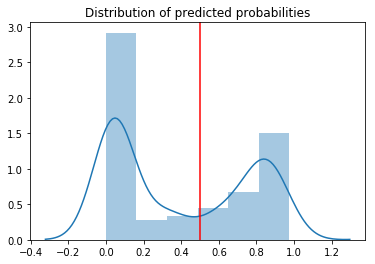

False Positive Rate 0.5908045977011495
True Positive Rate 0.005917159763313609


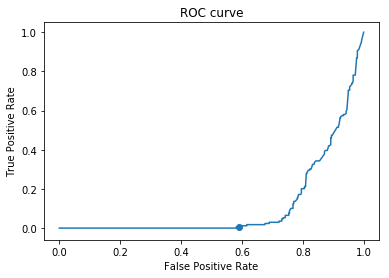

Area under the Receiver Operating Characteristic curve: 0.11493572740257091


In [76]:
set_threshold((y_val), (y_pred_proba))

### Pipeline + Model Val. Score

In [21]:
#pipeline time

!pip install category_encoders
import category_encoders as ce

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, n_jobs=-1)
    )

# Fit on train, score on val

pipeline.fit(X_train,y_train)
print('Validation Accuracy (random-split, top-35 feats)', pipeline.score(X_val,y_val))

pipeline.fit(re_X_train, re_y_train)
print('Validation Accuracy (time-split, top-35 feats < Wrangle)', pipeline.score(re_X_val, re_y_val)) 

# Wrangle 1 Accuracies: r-split(.774), t-split(.829)
# Wrangle 2 Accuracies: r-split(.772),t-split(.829) 
# no meaningful difference b/w cardinality < 11 and that < 51; time-based split consistently more accurate

Validation Accuracy (random-split, top-35 feats) 0.4755905511811024
Validation Accuracy (time-split, top-35 feats < Wrangle) 0.7787356321839081


In [0]:
# cross validation
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import cross_val_score

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
    )

k = 5
scores = cross_val_score(pipeline, X_train, y_train, cv=k, 
                         scoring='accuracy') #scoring changes w/type of model applied (cluster, class, regression)
print(f'Accuracy Score for {k} folds:', scores)

#Accuracy Score for 5 folds: [0.74448456 0.76314733 0.77550201 0.76697469 0.77099237] 

In [19]:
X_train.index
X_train.columns

Index(['Deep_Pov_Children', 'PovertyUnder18Num', 'PovertyAllAgesNum',
       'RuralUrbanContinuumCode2013', 'Type_2015_Update',
       'Low_Education_2015_update', 'Low_Employment_2015_update',
       'Population_loss_2015_update', 'Metro_Adjacent2013', 'Vets18OPct',
       'MaleVetsPct', 'PctVetsPoor', 'PctNonVetsPoor', 'PctVetsDisabilty',
       'PctNonVetsDisabilty', 'PopChangeRate1018', 'NetMigrationRate1018',
       'PopDensity2010', 'Under18Pct2010', 'Age65AndOlderPct2010',
       'ForeignBornPct', 'UnempRate2018', 'UnempRate2015', 'PctEmpChange1018',
       'PctEmpAgriculture', 'PctEmpMining', 'PctEmpConstruction',
       'PctEmpManufacturing', 'PctEmpTrade', 'PctEmpTrans',
       'PctEmpInformation', 'PctEmpFIRE', 'PctEmpServices', 'PctEmpGovt',
       'Metro-nonmetro status, 2013 0=Nonmetro 1=Metro',
       'Persistent_Poverty_2013', 'Persistent_Related_Child_Poverty_2013',
       'Economic Types Type_2015_Update non-overlapping', 'metro03',
       'MedHHInc', 'PerCapitaInc', 

### Feat Importances 

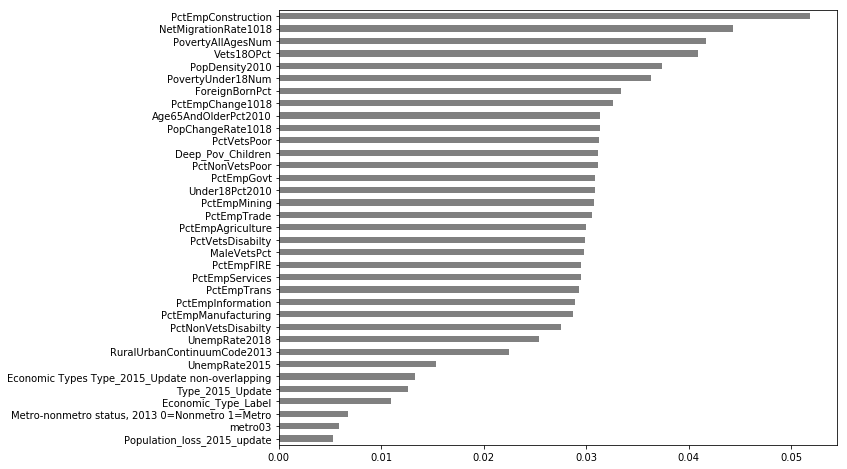

In [22]:
# feat. importances  #broken after 2nd iteration; doesn't work after passage through Wrangle2
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize = (10,8))
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)
importances.nlargest(n=35).sort_values().plot.barh(color = 'grey')

In [0]:
df_importances = pd.DataFrame(importances)
df_importances = df_importances.reset_index()
df_importances = df_importances.rename(columns={0: "value", "index": "feature"})
df_importances = df_importances.sort_values(by=['value'], ascending = False)
#df_importances.head(35) 
# now fetch a list of the most important feat names
list_feats = list(df_importances.feature)

### ptPlot - PctEmpConstruction vs 'low'

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

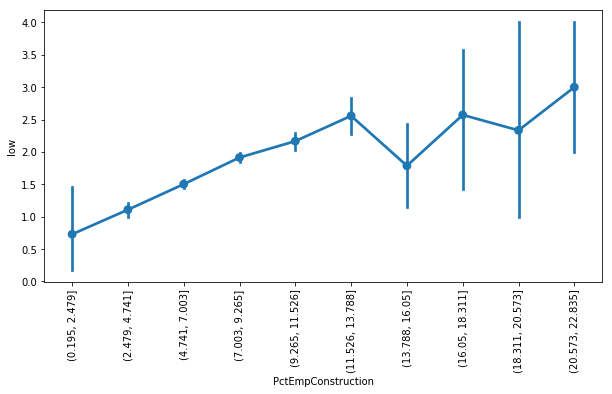

In [24]:
plt.figure(figsize = (10,5))
import seaborn as sns
sns.pointplot(x = pd.cut(train['PctEmpConstruction'],bins = 10), y = train['low'])
plt.xticks(rotation = 90) 